In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
from modeling_grad import SwavMolecule, ConformationDataset
from torch_geometric.loader import DataLoader
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, FastICA
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore', '.*TypedStorage is deprecated.*')

In [2]:
# load the data
PATH = r"/home/bobo/graduation/data/pku_val/data"
atom_inputs = torch.load(f"{PATH}/atom_inputs.pt")
aa_inputs = torch.load(f"{PATH}/aa_inputs.pt")
edge_index = torch.load(f"{PATH}/edge_index.pt")
cartesian_coord = torch.load(f"{PATH}/pt_coords.pt")
cartesian_coord = (cartesian_coord 
                   - cartesian_coord.sum(dim=1, keepdim=True) / cartesian_coord.shape[1])

dataset = ConformationDataset(
    cartesian_coord, atom_inputs, aa_inputs, edge_index)

In [3]:
num_atoms = dataset[0][0].unique().size(0)
num_aa = dataset[0][1].unique().size(0)
num_prototypes = 4
model = SwavMolecule(
    num_atom=num_atoms,
    num_aa=num_aa,
    coord_inputs_dim=3,
    node_dim=64,
    edge_attr_dim=64,
    global_attr_dim=64,
    dropout_prob=0.0,
    num_layers=12,
    num_prototypes=num_prototypes,
    use_projector=True,
    proj_hidden_dim=128,
    proj_output_dim=8,
    norm_type="graphnorm",
)

ROOT = "./"
ckpt_path = ROOT + "swav_mole.pth"
model.load_state_dict(torch.load(ckpt_path)['model'])

<All keys matched successfully>

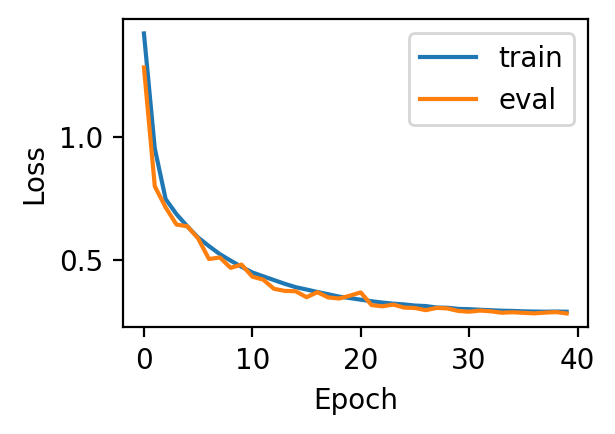

In [4]:
plt.figure(figsize=(3, 2), dpi=200)
plt.plot(np.load(ROOT + 'loss.npy'), label='train')
plt.plot(np.load(ROOT + 'eval_loss.npy'), label='eval')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [4]:
if torch.cuda.is_available():
    device = 'cuda'
    model = model.cuda()
    print('using cuda')
else:
    device = 'cpu'
    print('using cpu')

using cuda


In [5]:
batch_size = 512
temperature = 0.25
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [6]:
cluster_all = torch.empty((0))
u_all = torch.empty((0, 8))

for batch in tqdm(dataloader, total=len(dataloader)):
    model.eval()
    atom_id, amino_acids_id, data_batch = batch
    batch_size = atom_id.size(0)
    edge_index = data_batch.edge_index
    x = data_batch.x
    with torch.no_grad():
        res = model(
            x.to(device), 
            atom_id.to(device), 
            amino_acids_id.to(device), 
            edge_index.to(device)
        )
        scores = res['scores'].cpu()
        u = res['features'].cpu()
        z = u / u.norm(dim=1, keepdim=True, p=2)
        p = torch.nn.functional.softmax(scores / temperature, dim=-1)
        cluster = torch.argmax(p, dim=1)
        cluster_all = torch.concat((cluster_all, cluster), dim=0)
        u_all = torch.concat((u_all, u), dim=0)

100%|██████████| 977/977 [01:16<00:00, 12.79it/s]


In [8]:
np.save(ROOT + 'cluster.npy', cluster_all.numpy())
# np.save(ROOT + 'z.npy', z_all.numpy())

In [10]:
tors = pd.read_csv('../../tor_angles.traj', sep='    ', header=None, index_col=0)
tors.columns = ['phi', 'psi']
tors.index.name = 'frame'
tors['cluster'] = np.load(ROOT + 'cluster.npy')
# tors['cluster'] = cluster_all.numpy()

/tmp/ipykernel_6164/981937332.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tors = pd.read_csv('../../tor_angles.traj', sep='    ', header=None, index_col=0)


In [10]:
for cluster, frames in tors.groupby('cluster').groups.items():
    print(f'{cluster}: {len(frames)}')

0.0: 127264
1.0: 85502
2.0: 105251
3.0: 181983


Text(0, 0.5, '$\\psi (degree)$')

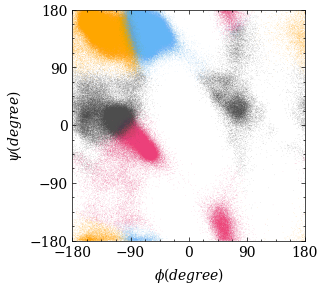

In [92]:
plt.style.use(['science', 'no-latex'])
fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
ax.scatter(tors['phi'], tors['psi'],
           edgecolors='none', alpha=0.5,
           s=0.1, c=tors['cluster'], cmap=cmap, norm=norm)
ax.autoscale(tight=True)
ax.set_xticks([-180, -90, 0 , 90 ,180])
ax.set_yticks([-180, -90, 0 , 90 ,180])
ax.set_xlabel(r"$\phi (degree)$")
ax.set_ylabel(r"$\psi (degree)$")
# fig.savefig(ROOT + 'cluster_4.png', dpi=600, bbox_inches='tight')

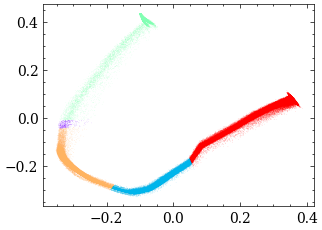

In [13]:
plt.scatter(u_all.numpy()[:,0], u_all.numpy()[:,1],
            edgecolors='none', alpha=0.5,
            s=0.1, c=tors['cluster'], cmap='rainbow')

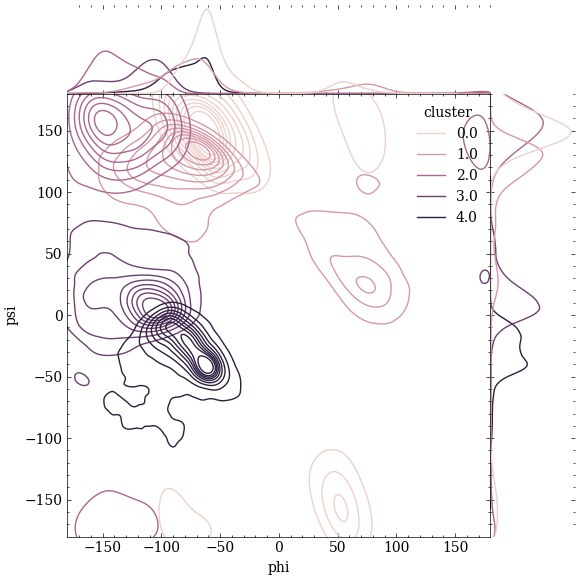

In [12]:
sfig = sns.jointplot(data=tors, x="phi", y="psi", hue='cluster',
                     kind="kde", space=0, xlim=[-180, 180], ylim=[-180, 180])

<Axes: xlabel='phi', ylabel='psi'>

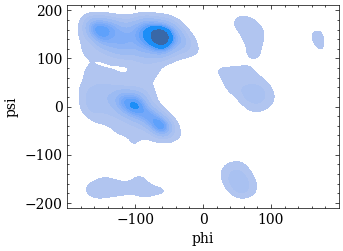

In [16]:
sns.kdeplot(data=tors, x="phi", y="psi", fill='True',)

<Axes: xlabel='phi', ylabel='psi'>

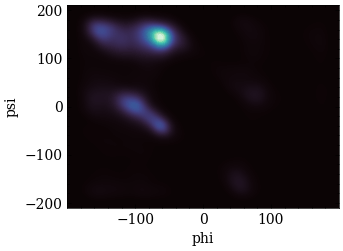

In [15]:
sns.kdeplot(data=tors, x="phi", y="psi", fill='True', thresh=0, levels=100, cmap="mako")

In [81]:
z_2d = TSNE(2, learning_rate='auto', init='random', random_state=0,
            perplexity=25, n_jobs=10).fit_transform(u_all.numpy())

In [13]:
z_2d.shape

(500000, 2)

In [18]:
import matplotlib.colors as mcolors

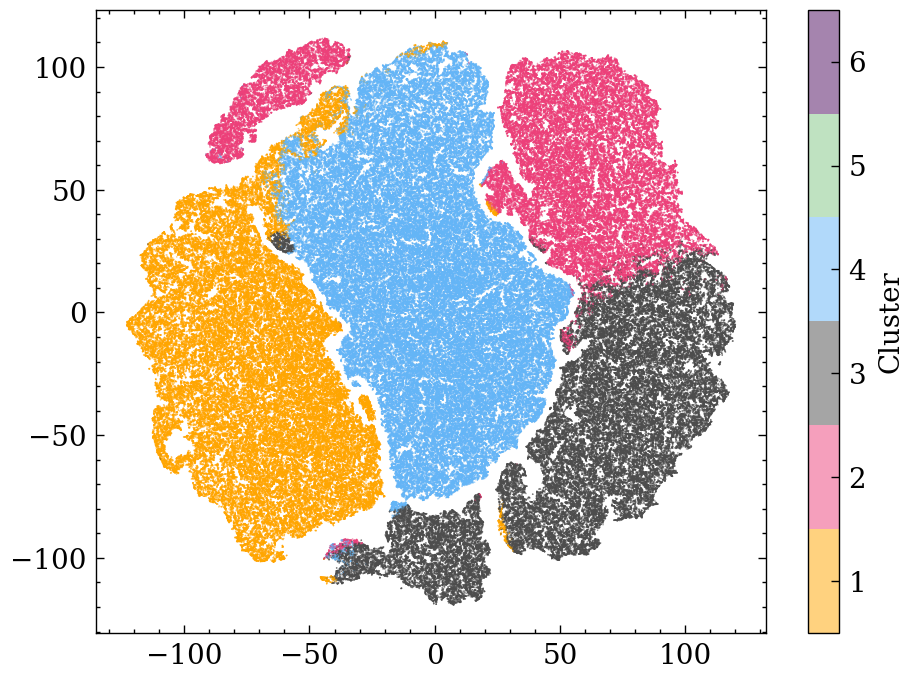

In [186]:
with plt.style.context(['science', 'no-latex']):
    fig, ax = plt.subplots(figsize=(6 * 0.9, 4.5 * 0.9), dpi=200)
    colors = ['#FFA600', '#EC407A', '#4D4D4D', '#64B5F6', '#81C784', '#4C0B5F']

    cmap = mcolors.ListedColormap(colors)
    norm = mcolors.Normalize(vmin=0, vmax=6)

    sctplot = ax.scatter(z_2d[:,0], z_2d[:,1], c=cluster_all.numpy(),
                         alpha=0.5,
                        linewidths=0.1, s=0.2, cmap=cmap, norm=norm)
    
    # ax.set_title('T-SNE Visualization of Mini-G Protein')

    cbar = fig.colorbar(mappable=sctplot)
    cbar.set_label('Cluster')
    cbar.set_ticks(np.arange(1, 7, 1) - 0.5)
    cbar.set_ticklabels(np.arange(1, 7, 1))
    cbar.minorticks_off()

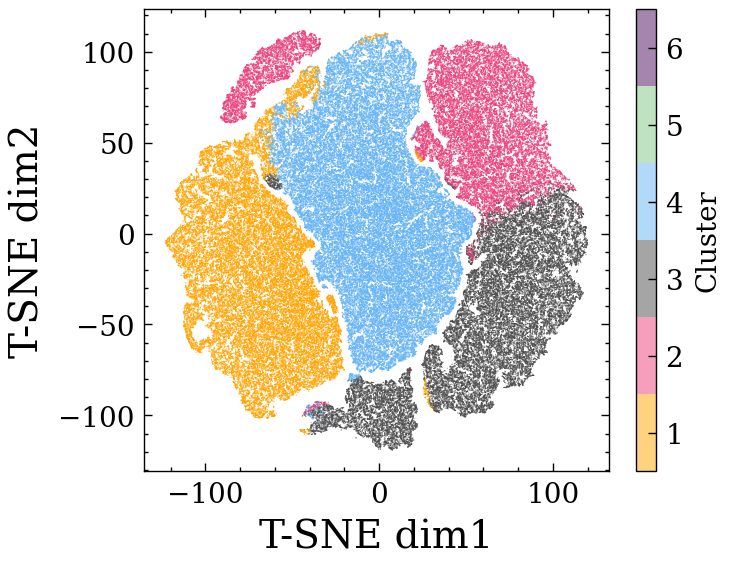

In [225]:
from matplotlib import gridspec 

with plt.style.context(['science', 'no-latex']):
    fig = plt.figure(figsize=(11 * 0.3, 10 * 0.3), dpi=200)
    grid = gridspec.GridSpec(20, 22)
    ax = fig.add_subplot(grid[:,:20])
    ax2 = fig.add_subplot(grid[:,21])
    colors = ['#FFA600', '#EC407A', '#4D4D4D', '#64B5F6', '#81C784', '#4C0B5F']

    cmap = mcolors.ListedColormap(colors)
    norm = mcolors.Normalize(vmin=0, vmax=6)
    
    sct = ax.scatter(z_2d[:,0], z_2d[:,1], c=cluster_all.numpy(),
               alpha=0.5, edgecolors='none',
               linewidths=0.1, s=0.1, cmap=cmap, norm=norm)
    
    ax.autoscale()
    ax.set_xlabel(r"T-SNE dim1", fontsize=14)
    ax.set_ylabel(r"T-SNE dim2", fontsize=14)
    cbar = fig.colorbar(mappable=sct, cax=ax2)
    cbar.set_label('Cluster')
    cbar.set_ticks(np.arange(1, 7, 1) - 0.5)
    cbar.set_ticklabels(np.arange(1, 7, 1))
    cbar.minorticks_off()
    
    fig.savefig('tsne-25.png', dpi=600, bbox_inches='tight')

In [89]:
pca = PCA(n_components=2)
z_pca = pca.fit_transform(u_all.numpy())

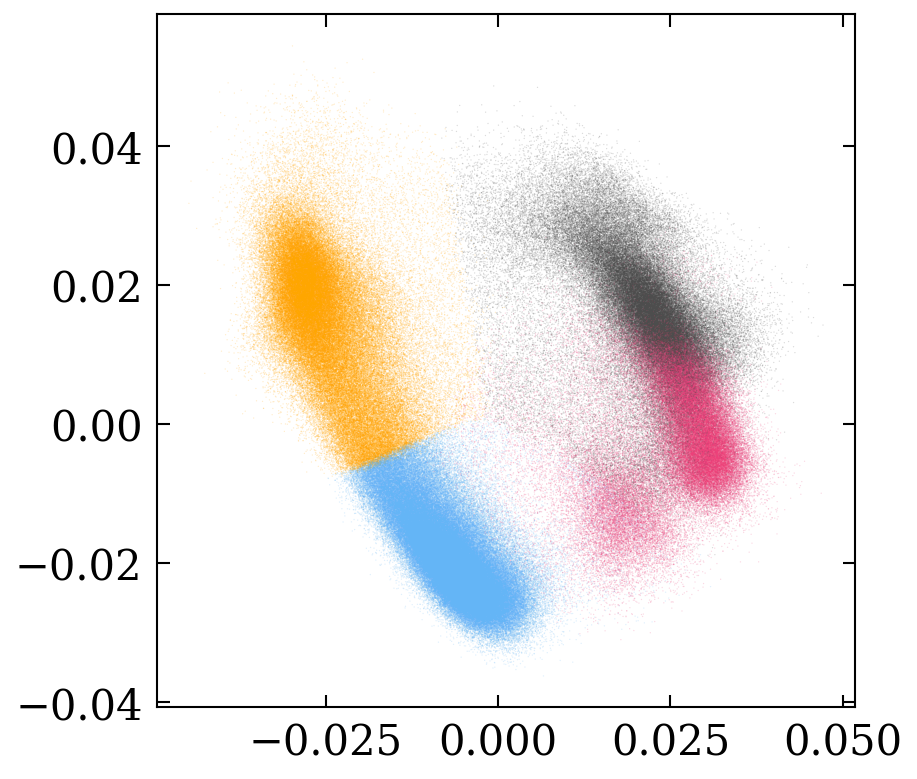

In [91]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
colors = cluster_all.numpy()

ax.scatter(z_pca[:,0], z_pca[:,1], c=colors,
           s=0.1, edgecolors='none', alpha=0.2, cmap=cmap, norm=norm)
ax.minorticks_off()
#ax.set_xticks([-1, -0.5, 0 , 0.5, 1])
#ax.set_yticks([-1, -0.5, 0 , 0.5, 1])
#ax.set_xlim([-1, 1])
#ax.set_ylim([-1, 1])

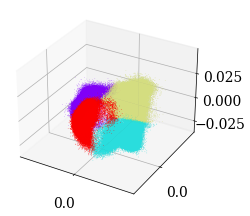

In [15]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

pca = PCA(n_components=3)
z_pca = pca.fit_transform(u_all.numpy())

ax.scatter(z_pca[:,0], z_pca[:,1], z_pca[:,2], c=cluster_all.numpy(),
            linewidths=0.1, s=0.1, cmap='rainbow')
ax.set_xticks([-1, -0.5, 0 , 0.5, 1])
ax.set_yticks([-1, -0.5, 0 , 0.5, 1])
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.autoscale()

In [23]:
cartesian_coord = torch.load(f"{PATH}/pt_coords.pt")

In [25]:
cartesian_coord.shape

torch.Size([500000, 22, 3])

In [28]:
mc = 

In [33]:
(cartesian_coord - mc)

tensor([[[-5.4186e-08,  3.5221e-08, -1.6256e-08]],

        [[-6.5023e-08, -2.1674e-08,  1.0837e-08]],

        [[ 4.3349e-08, -3.2512e-08, -4.3349e-08]],

        ...,

        [[-5.4186e-08,  1.6256e-08,  2.1674e-08]],

        [[-2.1674e-08, -2.7093e-08, -7.5860e-08]],

        [[-1.0837e-08,  1.0837e-08, -5.4186e-08]]])

In [1]:
import torch
a = torch.randn((5, 5))

In [2]:
a

tensor([[ 0.2977, -0.6738, -0.4478,  1.0381, -0.9309],
        [ 0.8300,  0.2522,  0.4121,  0.5541,  1.6798],
        [ 0.5385, -0.7298,  0.9496, -2.3913,  0.0340],
        [-1.5772,  1.2968, -2.0456,  1.3618, -1.5013],
        [ 0.6611, -1.4623, -1.8325,  1.7346,  0.0962]])

In [3]:
# if a > 0, a = a + 1, if a < 0, a = exp(a)
a = torch.where(a > 0, a + 1, torch.exp(a))
a

tensor([[1.2977, 0.5098, 0.6391, 2.0381, 0.3942],
        [1.8300, 1.2522, 1.4121, 1.5541, 2.6798],
        [1.5385, 0.4820, 1.9496, 0.0915, 1.0340],
        [0.2066, 2.2968, 0.1293, 2.3618, 0.2229],
        [1.6611, 0.2317, 0.1600, 2.7346, 1.0962]])

In [6]:
# make sum of all rows sum is 1
a.sum(dim=0) / a.sum()
# Q: pls optimize the previous row's code
# A:
a.sum(dim=0, keepdim=True) / a.sum()
# Q: why?
# A: because we want to keep the dimension of the tensor
# Q: why we want?
# A: because we want to broadcast the tensor to the original shape
# Q why we want?
# A: because we want to divide the tensor by the sum of all rows
# Q: why we want?
# A: because we want to make the sum of all rows sum is 1



tensor([[0.2192, 0.1601, 0.1439, 0.2946, 0.1821]])

In [11]:
kmeans = KMeans(n_clusters=6, 
                random_state=1919, 
                n_init='auto', 
                algorithm='elkan').fit(u_all.numpy())

In [12]:
kmeans.labels_

array([1, 1, 1, ..., 4, 4, 1], dtype=int32)

In [20]:
colors = ['#FFA600', '#EC407A', '#4D4D4D', '#64B5F6', '#81C784', '#4C0B5F']

cmap = mcolors.ListedColormap(colors)
norm = mcolors.Normalize(vmin=0, vmax=6)

In [24]:
tors['kmeans_cluster'] = kmeans.labels_

In [44]:
tors

,phi,psi,cluster,kmeans_cluster,index
frame,,,,,
100,-96.3548,-10.6779,2.0,1,0
200,-111.9346,12.7832,2.0,1,1
300,-97.7805,1.5015,2.0,1,2
400,-102.4227,-19.4079,2.0,1,3
500,-76.5173,-14.4265,1.0,4,4
...,...,...,...,...,...
49999600,-132.5089,-71.3991,1.0,1,499995
49999700,-126.3647,-50.7047,1.0,4,499996
49999800,-120.1516,-15.9450,1.0,4,499997


In [47]:
tors['kmeans_distance'] = tors.apply(lambda x: np.linalg.norm(u_all[int(x['index'])] - kmeans.cluster_centers_[int(x['kmeans_cluster'])]), axis=1)

In [56]:
# take the row of smallest distance of each kmeans cluster
min_distance = tors.groupby('kmeans_cluster').apply(lambda x: x.loc[x['kmeans_distance'].idxmin()])

In [67]:
min_distance['cluster'] = min_distance['cluster'].astype(int)
min_distance['kmeans_cluster'] = min_distance['kmeans_cluster'].astype(int)
min_distance['index'] = min_distance['index'].astype(int)
min_distance.to_json("./min_distance.json", orient='records')

Text(0, 0.5, '$\\psi (degree)$')

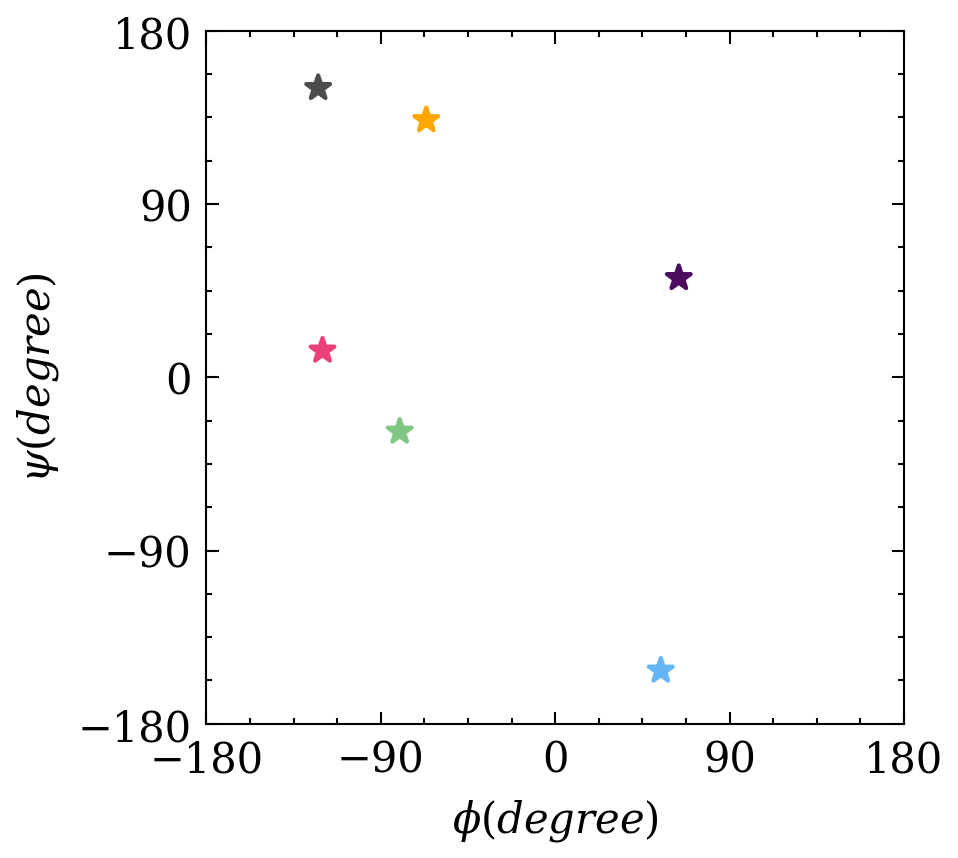

In [62]:
# visualize min_distance
fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
ax.scatter(min_distance['phi'], min_distance['psi'], 
           c=min_distance['kmeans_cluster'], cmap=cmap, norm=norm,
           marker='*')
ax.autoscale(tight=True)
ax.set_xticks([-180, -90, 0 , 90 ,180])
ax.set_yticks([-180, -90, 0 , 90 ,180])
ax.set_xlabel(r"$\phi (degree)$")
ax.set_ylabel(r"$\psi (degree)$")

In [50]:
u_all[0]

tensor([-0.0001, -0.0143,  0.0003,  0.0011, -0.0034, -0.0064, -0.0126, -0.0109])

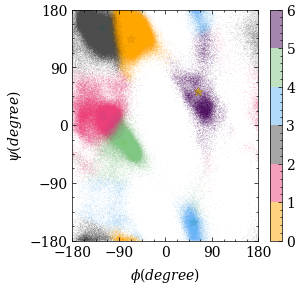

In [64]:
plt.style.use(['science', 'no-latex'])
fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
ax.scatter(min_distance['phi'], min_distance['psi'], 
           c=min_distance['kmeans_cluster'],
           marker='*')
mp = ax.scatter(tors['phi'], tors['psi'],
           edgecolors='none', alpha=0.5,
           s=0.1, c=kmeans.labels_, cmap=cmap, norm=norm)
ax.autoscale(tight=True)
ax.set_xticks([-180, -90, 0 , 90 ,180])
ax.set_yticks([-180, -90, 0 , 90 ,180])
ax.set_xlabel(r"$\phi (degree)$")
ax.set_ylabel(r"$\psi (degree)$")
plt.colorbar(mp)

In [213]:
def change_color(npar, a, b):
    npar = np.where(npar == a, -1, npar)
    npar = np.where(npar == b, -2, npar)
    npar = np.where(npar == -1, b, npar)
    npar = np.where(npar == -2, a, npar)
    return npar

In [220]:
clrs = kmeans.labels_
clrs = change_color(clrs, 0, 2)
clrs = change_color(clrs, 1, 4)
clrs = change_color(clrs, 2, 3)
clrs = change_color(clrs, 2, 4)

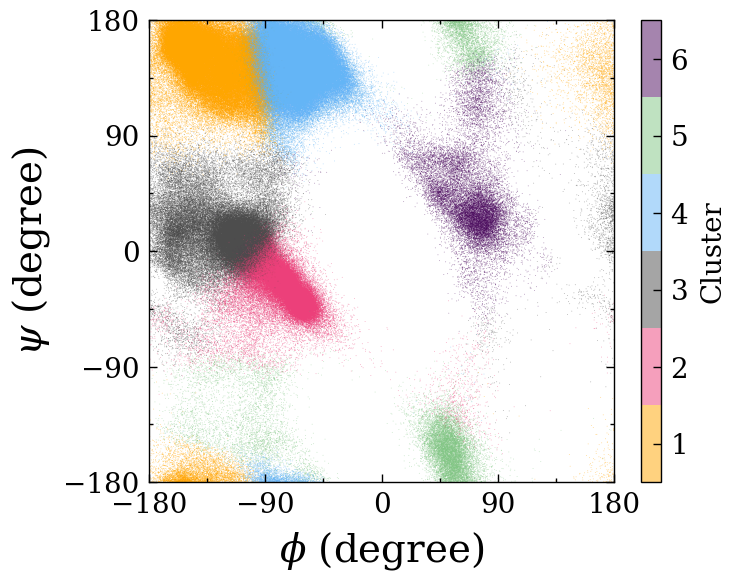

In [223]:
with plt.style.context(['science', 'no-latex']):
    fig = plt.figure(figsize=(11 * 0.3, 10 * 0.3), dpi=200)
    grid = gridspec.GridSpec(20, 22)
    ax = fig.add_subplot(grid[:,:20])
    ax2 = fig.add_subplot(grid[:,21])
    colors = ['#FFA600', '#EC407A', '#4D4D4D', '#64B5F6', '#81C784', '#4C0B5F']

    cmap = mcolors.ListedColormap(colors)
    norm = mcolors.Normalize(vmin=0, vmax=6)
    
    sct = ax.scatter(tors['phi'], tors['psi'], 
                     c=clrs,
                     alpha=0.5, edgecolors='none',
                     s=0.1, cmap=cmap, norm=norm)
    
    ax.autoscale(tight=True)
    ax.set_xticks([-180, -90, 0 , 90 ,180])
    ax.set_xticks([-135, -45, 45, 135], minor=True)
    ax.set_yticks([-180, -90, 0 , 90 ,180])
    ax.set_yticks([-135, -45, 45, 135], minor=True)
    ax.set_xlabel(r"$\phi$ (degree)", fontsize=14)
    ax.set_ylabel(r"$\psi$ (degree)", fontsize=14)
    cbar = fig.colorbar(mappable=sct, cax=ax2)
    cbar.set_label('Cluster')
    cbar.set_ticks(np.arange(1, 7, 1) - 0.5)
    cbar.set_ticklabels(np.arange(1, 7, 1))
    cbar.minorticks_off()
    
    fig.savefig('kmeans-6.png', dpi=600, bbox_inches='tight')

In [3]:
df = pd.read_json('min_distance.json', orient='records')

In [4]:
df

,phi,psi,cluster,kmeans_cluster,index,kmeans_distance
0,-66.4993,133.6125,3,0,417964,0.000812
1,-120.0534,13.9113,2,1,90914,0.001263
2,-122.3009,150.3103,0,2,442075,0.001267
3,54.5360,-152.3464,1,3,264778,0.003249
4,-80.2065,-28.1999,1,4,467184,0.001289
5,63.8339,51.5732,2,5,442944,0.002420


In [7]:
cc = cartesian_coord[df['index']].numpy()

In [8]:
np.save('center_coords.npy', cc)